# Merge Training Data Frame

The goal of this notebook is to join the sales and shooting data to create a dataframe suitable for training and prediction.

In [1]:
import pandas
import numpy as N
import tqdm
import matplotlib.pyplot as pyplot
import seaborn
from pathlib import Path

seaborn.set_style('whitegrid')

## Loading auxiliary data

In [2]:
dfZip = pandas.read_csv('data/nyc_zipcodes.csv')
dfCPI = pandas.read_csv('data/cpi.csv')
mapCPI = {year:cpi for year,cpi in zip(dfCPI['year'], dfCPI['cpi'])}

dfBorough = pandas.read_csv('data/borough.csv')
mapBorough = {i:name for i,name in zip(dfBorough['id'], dfBorough['borough'])}

dfFilterCategory = pandas.read_csv('data/filter_building_class_category.csv')
mapCategories = {c:name for c,name in zip(dfFilterCategory['category'], dfFilterCategory['name'])}

In [3]:
dfSales = pandas.read_csv('processed/sales.csv')
dfSales['SALE DATE'] = pandas.to_datetime(dfSales['SALE DATE'])
dfSales

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,402,42,,S1,96 AVENUE B,,...,1,1,2,1400,1839,1901,1,S1,0,2014-12-05
1,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,372,37,,S2,17 AVENUE D,,...,2,1,3,826,2075,1910,1,S2,0,2014-01-31
2,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377,66,,C0,243 EAST 7TH STREET,,...,3,0,3,2381,3084,1899,1,C0,2900000,2014-11-26
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,51,,C7,300 EAST 2ND STREET,,...,8,2,10,2650,7620,1920,2,C7,0,2014-07-18
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,373,15,,D1,324 EAST 4TH STREET,,...,11,0,11,2212,8294,1920,2,C3,0,2014-05-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571739,1,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2180,1323,,R4,210 BENNETT AVENUE,5C,...,1,0,1,0,0,2008,2,R4,319410,2011-08-04
571740,1,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2180,1325,,R4,210 BENNETT AVENUE,5E,...,1,0,1,0,0,2008,2,R4,385067,2011-06-10
571741,1,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2180,1327,,R4,210 BENNETT AVENUE,6B,...,1,0,1,0,0,2008,2,R4,505000,2011-06-07
571742,1,WASHINGTON HEIGHTS UPPER,28 COMMERCIAL CONDOS,4,2180,1230,,R5,736 WEST 187 STREET,PRK30,...,0,1,1,0,0,2003,4,R5,0,2011-04-22


### Filter the building class categories and price

When the price is 0,  the specification indicates that this is a transfer of property (e.g. inheritance) and should not be counted as a 'sale'. We also filter the building class categories.

In [4]:
maskCategory = dfSales['BUILDING CLASS CATEGORY'].map(lambda x:x in mapCategories)
maskPrice = dfSales['SALE PRICE'] > 0
dfSales = dfSales[maskCategory & maskPrice].reset_index()

### Add year, real price, etc.

In [5]:
dfSales['year'] = dfSales['SALE DATE'].map(lambda x:x.year)
dfSales['real price'] = [price / mapCPI[year] * 100 for price,year in zip(dfSales['SALE PRICE'], dfSales['year'])]
# According to our data analysis New York changed the designation "Homes" to "Dwellings" in 2013. We rectify the change here.
dfSales['category'] = dfSales['BUILDING CLASS CATEGORY'].map(lambda x:mapCategories[x])
dfSales['BOROUGH'] = dfSales['BOROUGH'].map(lambda x:mapBorough[x])

In [6]:
dfSales.columns

Index(['index', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'year', 'real price', 'category'],
      dtype='object')

The process of sales data is now complete. Now we turn to shooting data.

## Shooting data

In [7]:
dfShooting = pandas.read_csv('processed/shooting.csv')
dfShooting

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,...,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,zip code,year
0,24050482,08/27/2006,05:35:00,BRONX,52,0.0,NaN,True,NaN,NaN,...,25-44,F,BLACK HISPANIC,1.017542e+06,255918.875000,40.869058,-73.879632,POINT (-73.87963173099996 40.86905819000003),10467,2006
1,77673979,03/11/2011,12:03:00,QUEENS,106,0.0,NaN,False,NaN,NaN,...,65+,M,WHITE,1.027543e+06,186095.000000,40.677367,-73.843920,POINT (-73.84392019199998 40.677366895000034),11417,2011
2,203350417,10/06/2019,01:09:00,BROOKLYN,77,0.0,NaN,False,NaN,NaN,...,18-24,F,BLACK,9.953250e+05,185155.000000,40.674886,-73.960075,POINT (-73.96007501899999 40.674885741000026),11238,2019
3,80584527,09/04/2011,03:35:00,BRONX,40,0.0,NaN,False,NaN,NaN,...,<18,M,BLACK,1.007453e+06,233952.000000,40.808798,-73.916184,POINT (-73.91618413199996 40.80879780500004),10454,2011
4,90843766,05/27/2013,21:16:00,QUEENS,100,0.0,NaN,False,NaN,NaN,...,18-24,M,BLACK,1.041267e+06,157133.515625,40.597796,-73.794686,POINT (-73.79468553799995 40.597796249000055),11692,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23580,186329304,08/12/2018,19:50:00,BROOKLYN,84,0.0,NaN,False,25-44,M,...,65+,M,BLACK,9.891547e+05,193164.265625,40.696875,-73.982314,POINT (-73.98231375199998 40.69687491500008),11201,2018
23581,29277330,05/26/2007,04:57:00,BROOKLYN,81,0.0,NaN,False,NaN,NaN,...,25-44,M,BLACK,1.005218e+06,190528.000000,40.689615,-73.924393,POINT (-73.92439311199996 40.689615497000034),11221,2007
23582,77443443,02/25/2011,01:12:00,BROOKLYN,81,0.0,MULTI DWELL - APT BUILD,False,18-24,M,...,<18,M,BLACK,1.003999e+06,187611.031250,40.681612,-73.928798,POINT (-73.92879814299994 40.681611891000045),11233,2011
23583,176027888,03/17/2018,00:46:00,BRONX,43,0.0,NaN,False,25-44,M,...,25-44,M,WHITE HISPANIC,1.018728e+06,242744.234375,40.832893,-73.875408,POINT (-73.87540796899998 40.83289318000004),10472,2018


In [8]:
series = dfShooting.groupby(['zip code', 'year'])['zip code', 'year'].size()
series

/tmp/ipykernel_123/193236668.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  series = dfShooting.groupby(['zip code', 'year'])['zip code', 'year'].size()


zip code  year
100       2006    1
          2008    1
          2012    1
10001     2006    7
          2007    3
                 ..
12692     2006    2
          2009    1
          2011    1
          2012    1
          2013    1
Length: 1997, dtype: int64

In [9]:
dfCrimeStat = pandas.DataFrame(series, columns=['count']).reset_index()
dfCrimeStat

,zip code,year,count
0,100,2006,1
1,100,2008,1
2,100,2012,1
3,10001,2006,7
4,10001,2007,3
...,...,...,...
1992,12692,2006,2
1993,12692,2009,1
1994,12692,2011,1
1995,12692,2012,1


<AxesSubplot:xlabel='count', ylabel='Count'>

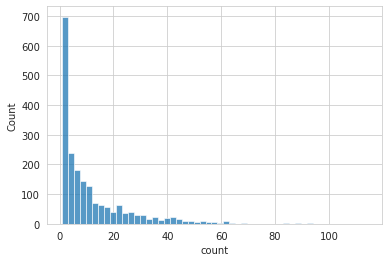

In [10]:
seaborn.histplot(dfCrimeStat['count'])

In [11]:
mapCrimeStat = {}

for z,y,count in tqdm.tqdm(zip(dfCrimeStat['zip code'], dfCrimeStat['year'], dfCrimeStat['count'])):
    y = int(y)
    if ':' in z:
        z1,z2 = z.split(':')
        z1 = int(z1)
        z2 = int(z2)
        mapCrimeStat[(z1, y)] = count
        mapCrimeStat[(z2, y)] = count
    elif '-' in z:
        z,_ = z.split('-')
        z = int(z)
        mapCrimeStat[(z, y)] = count
    else:
        z = int(z)
        mapCrimeStat[(z, y)] = count
def get_count(zc, year):
    return mapCrimeStat.get((int(zc), int(year)), 0)

1997it [00:00, 971922.15it/s]


In [12]:
nPrevYears = 4
keysPrevYears = []
for n in range(1,nPrevYears+1):
    key = f"Crimes_{n}"
    keysPrevYears.append(key)
    
    dfSales[key] = [get_count(zc, year-n) for zc,year in zip(dfSales['ZIP CODE'], dfSales['year'])]
dfSales

,index,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,year,real price,category,Crimes_1,Crimes_2,Crimes_3,Crimes_4
0,104,Manhattan,ALPHABET CITY,10 COOPS - ELEVATOR APARTMENTS,2,386,58,,D4,"223-25 EAST 3RD STREET, 3B",...,D4,425000,2014-03-21,2014,179552.175750,Coop Apartment,2,4,5,4
1,105,Manhattan,ALPHABET CITY,10 COOPS - ELEVATOR APARTMENTS,2,387,44,,D4,"283 EAST 4TH ST, 5A",...,D4,275000,2014-01-31,2014,116180.819603,Coop Apartment,2,4,5,4
2,106,Manhattan,ALPHABET CITY,10 COOPS - ELEVATOR APARTMENTS,2,387,44,,D4,"283 EAST 4TH STREET, 6A",...,D4,352000,2014-10-31,2014,148711.449092,Coop Apartment,2,4,5,4
3,108,Manhattan,ALPHABET CITY,10 COOPS - ELEVATOR APARTMENTS,2,387,44,,D4,283 EAST 4TH STREET,...,D4,749600,2014-11-06,2014,316687.790452,Coop Apartment,2,4,5,4
4,109,Manhattan,ALPHABET CITY,10 COOPS - ELEVATOR APARTMENTS,2,387,44,,D4,"283 EAST 4TH STREET, 3B",...,D4,175000,2014-11-06,2014,73933.248838,Coop Apartment,2,4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271705,571737,Manhattan,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2180,1320,,R4,210 BENNETT AVENUE,...,R4,340000,2011-06-01,2011,151178.301467,Condo Apartment,4,25,15,4
271706,571738,Manhattan,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2180,1322,,R4,210 BENNETT AVENUE,...,R4,459342,2011-08-08,2011,204242.774566,Condo Apartment,4,25,15,4
271707,571739,Manhattan,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2180,1323,,R4,210 BENNETT AVENUE,...,R4,319410,2011-08-04,2011,142023.121387,Condo Apartment,4,25,15,4
271708,571740,Manhattan,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2180,1325,,R4,210 BENNETT AVENUE,...,R4,385067,2011-06-10,2011,171216.985327,Condo Apartment,4,25,15,4


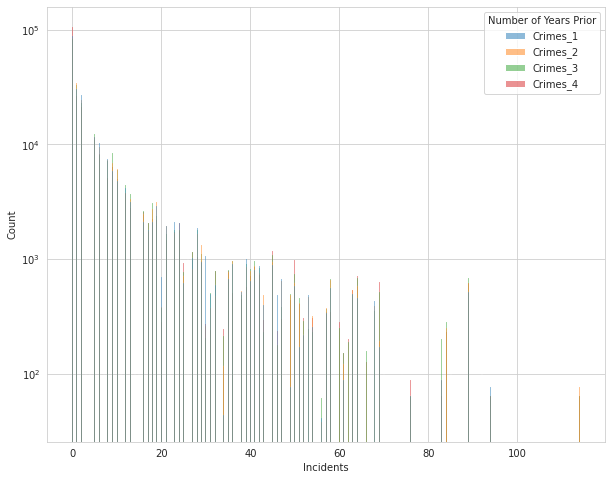

In [84]:
dfPlot = dfSales[keysPrevYears].melt(var_name='Number of Years Prior', value_name='Incidents')
fig, ax = pyplot.subplots(figsize=(10,8))
seaborn.histplot(dfPlot, x='Incidents', hue='Number of Years Prior', ax=ax)
ax.set_yscale('log')
fig.savefig('figures/hist_incidents_years_prior.png', dpi=300)

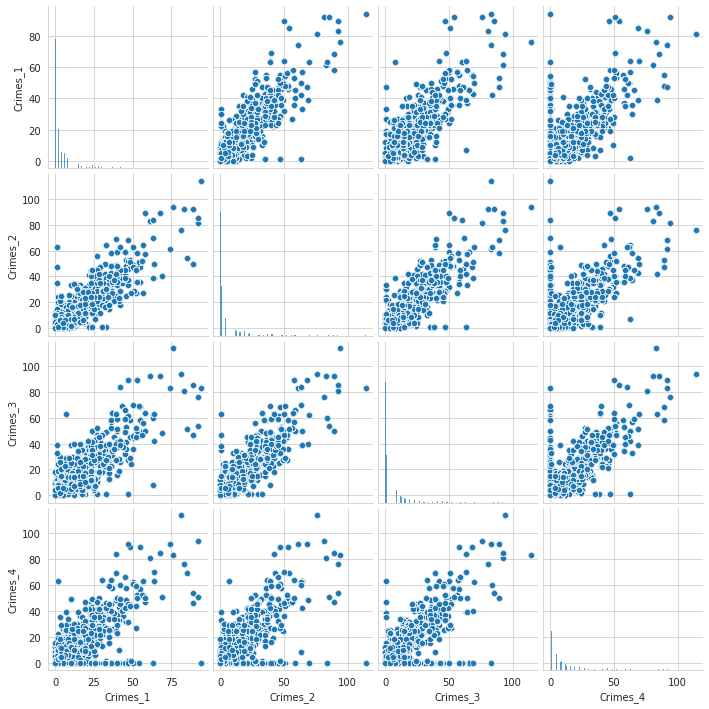

In [85]:
dfPlot = dfSales[keysPrevYears]
seaborn.pairplot(dfPlot)
pyplot.savefig('figures/crimes_correlation.png', dpi=300)

## Output training data

In [86]:
dfSales.to_csv('training/data_all.csv', index=False)
dfSales[['BOROUGH', 'year', 'real price', 'category', *keysPrevYears]].to_csv('training/data.csv', index=False)

## Mean Price Only

Maybe we should predict mean price instead of individual price.

In [16]:
dfSalesMean = dfSales[['BOROUGH', 'year', 'real price', 'category', *keysPrevYears]].groupby(['BOROUGH', 'year', 'category', *keysPrevYears]).mean()
dfSalesMean = dfSalesMean.reset_index()
dfSalesMean

,BOROUGH,year,category,Crimes_1,Crimes_2,Crimes_3,Crimes_4,real price
0,Bronx,2009,1 Family Dwelling,0,0,0,0,431949.523204
1,Bronx,2009,1 Family Dwelling,1,1,2,0,36400.000000
2,Bronx,2009,1 Family Dwelling,4,2,13,0,152629.111629
3,Bronx,2009,1 Family Dwelling,4,3,4,0,154295.212480
4,Bronx,2009,1 Family Dwelling,4,7,11,0,122971.028971
...,...,...,...,...,...,...,...,...
3435,Staten Island,2015,Condo Apartment,8,14,9,8,217712.983330
3436,Staten Island,2015,Condo Apartment,10,16,10,13,83122.362869
3437,Staten Island,2015,Coop Apartment,4,3,5,0,76132.208158
3438,Staten Island,2015,Coop Apartment,8,14,9,8,85589.476297


In [17]:
dfSalesMean.to_csv('training/data_mean.csv', index=False)